In [1]:
import sys
sys.path.insert(0, 'I:/Winter-Break-Research/src')
sys.path.insert(0, 'I:/Winter-Break-Research/scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data và Chạy Backtest

In [2]:
# Load price data
prices = pd.read_csv('I:/Winter-Break-Research/data/raw/etf_prices_fresh.csv', 
                     index_col='Date', parse_dates=True)
print(f"Loaded: {prices.shape[1]} ETFs, {prices.shape[0]} days")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")

Loaded: 118 ETFs, 5012 days
Date range: 2005-01-03 00:00:00 to 2024-11-29 00:00:00


In [3]:
# Import optimized backtest functions
from optimized_backtest import (
    OptimizedConfig, 
    run_optimized_backtest,
    parallel_cointegration_test,
    vectorized_zscore_all_pairs,
    vectorized_trading_simulation,
    compute_pair_score
)

# Config
cfg = OptimizedConfig(
    pvalue_threshold=0.05,
    min_half_life=5,
    max_half_life=60,
    top_pairs=20,
    entry_z=2.0,
    exit_z=0.5,
    stop_loss_z=4.0,
    n_workers=4
)

print("Config:")
print(f"  p-value threshold: {cfg.pvalue_threshold}")
print(f"  Half-life range: {cfg.min_half_life}-{cfg.max_half_life} days")
print(f"  Top pairs: {cfg.top_pairs}")
print(f"  Entry/Exit/Stop-loss Z: {cfg.entry_z}/{cfg.exit_z}/{cfg.stop_loss_z}")

Config:
  p-value threshold: 0.05
  Half-life range: 5-60 days
  Top pairs: 20
  Entry/Exit/Stop-loss Z: 2.0/0.5/4.0


In [4]:
# Run backtest
import warnings
warnings.filterwarnings('ignore')

year_results, summary_df = run_optimized_backtest(
    prices, cfg, start_year=2008, end_year=2024
)

print("\n" + "="*60)
print("BACKTEST SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))

2025-12-02 15:07:30,293 - INFO - 
2025-12-02 15:07:30,294 - INFO - Year 2008: Formation 2007
2025-12-02 15:07:30,294 - INFO - ============================================================
2025-12-02 15:07:30,300 - INFO - Formation: 2007-01-01 to 2007-12-31, 96 tickers
2025-12-02 15:07:30,294 - INFO - Year 2008: Formation 2007
2025-12-02 15:07:30,294 - INFO - ============================================================
2025-12-02 15:07:30,300 - INFO - Formation: 2007-01-01 to 2007-12-31, 96 tickers
2025-12-02 15:07:30,322 - INFO - Pairs with 0.6 <= corr <= 0.95: 3105
2025-12-02 15:07:30,322 - INFO - Pairs with 0.6 <= corr <= 0.95: 3105
2025-12-02 15:07:31,323 - INFO - Cointegrated pairs (p<0.05, HL 5-60): 358
2025-12-02 15:07:31,325 - INFO - Selected TOP 20 pairs by quality score:
2025-12-02 15:07:31,326 - INFO -   1. ('VGT', 'ITA'): score=0.708, p=0.0010, HL=7.3
2025-12-02 15:07:31,327 - INFO -   2. ('IWM', 'IWD'): score=0.696, p=0.0010, HL=6.5
2025-12-02 15:07:31,328 - INFO -   3. ('IY


BACKTEST SUMMARY
 trading_year  pairs_selected  total_trades  winning_trades  win_rate    total_pnl  return_pct
         2008              20            56              35 62.500000     7.946824    0.007947
         2009              20            61              41 67.213115  3687.714995    3.687715
         2010              20            59              32 54.237288 -1329.157191   -1.329157
         2011              20            59              34 57.627119 -2257.410685   -2.257411
         2012              20            69              46 66.666667  1502.428286    1.502428
         2013              20            30              10 33.333333 -4500.656249   -4.500656
         2014              20            46              18 39.130435 -9053.871971   -9.053872
         2015              20            67              44 65.671642   642.354530    0.642355
         2016              20            74              51 68.918919  1019.738141    1.019738
         2017              20   

## 2. Phân Tích Theo Năm

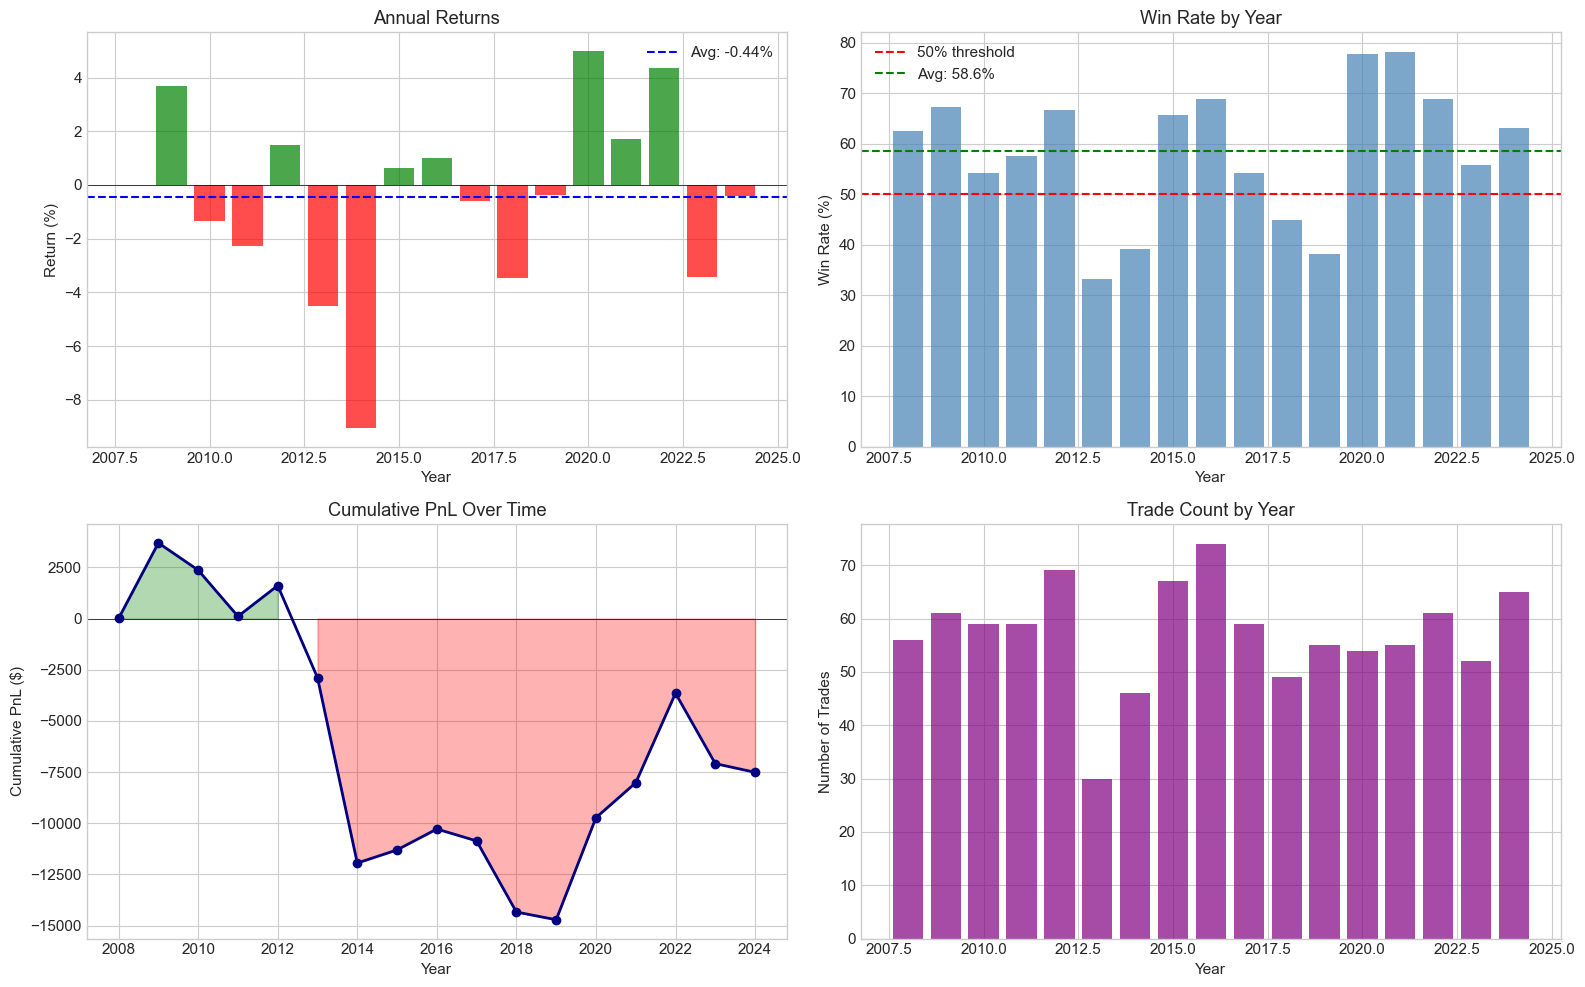

In [5]:
# Yearly performance chart
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Return by year
colors = ['green' if x > 0 else 'red' for x in summary_df['return_pct']]
axes[0, 0].bar(summary_df['trading_year'], summary_df['return_pct'], color=colors, alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].axhline(y=summary_df['return_pct'].mean(), color='blue', linestyle='--', label=f"Avg: {summary_df['return_pct'].mean():.2f}%")
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].set_title('Annual Returns')
axes[0, 0].legend()

# Win rate by year
axes[0, 1].bar(summary_df['trading_year'], summary_df['win_rate'], color='steelblue', alpha=0.7)
axes[0, 1].axhline(y=50, color='red', linestyle='--', label='50% threshold')
axes[0, 1].axhline(y=summary_df['win_rate'].mean(), color='green', linestyle='--', label=f"Avg: {summary_df['win_rate'].mean():.1f}%")
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate by Year')
axes[0, 1].legend()

# Cumulative PnL
cumulative_pnl = summary_df['total_pnl'].cumsum()
axes[1, 0].plot(summary_df['trading_year'], cumulative_pnl, marker='o', color='navy', linewidth=2)
axes[1, 0].fill_between(summary_df['trading_year'], 0, cumulative_pnl, alpha=0.3, 
                        where=(cumulative_pnl >= 0), color='green')
axes[1, 0].fill_between(summary_df['trading_year'], 0, cumulative_pnl, alpha=0.3, 
                        where=(cumulative_pnl < 0), color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Cumulative PnL ($)')
axes[1, 0].set_title('Cumulative PnL Over Time')

# Trades per year
axes[1, 1].bar(summary_df['trading_year'], summary_df['total_trades'], color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Trades')
axes[1, 1].set_title('Trade Count by Year')

plt.tight_layout()
plt.savefig('I:/Winter-Break-Research/results/figures/yearly_analysis.png', dpi=150)
plt.show()

In [6]:
# Identify winning vs losing years
winning_years = summary_df[summary_df['return_pct'] > 0]
losing_years = summary_df[summary_df['return_pct'] <= 0]

print("WINNING YEARS:")
print(winning_years[['trading_year', 'return_pct', 'win_rate', 'total_trades']].to_string(index=False))
print(f"\nAvg return in winning years: {winning_years['return_pct'].mean():.2f}%")
print(f"Avg win rate in winning years: {winning_years['win_rate'].mean():.1f}%")

print("\n" + "-"*50)
print("LOSING YEARS:")
print(losing_years[['trading_year', 'return_pct', 'win_rate', 'total_trades']].to_string(index=False))
print(f"\nAvg return in losing years: {losing_years['return_pct'].mean():.2f}%")
print(f"Avg win rate in losing years: {losing_years['win_rate'].mean():.1f}%")

WINNING YEARS:
 trading_year  return_pct  win_rate  total_trades
         2008    0.007947 62.500000            56
         2009    3.687715 67.213115            61
         2012    1.502428 66.666667            69
         2015    0.642355 65.671642            67
         2016    1.019738 68.918919            74
         2020    4.985851 77.777778            54
         2021    1.706126 78.181818            55
         2022    4.373395 68.852459            61

Avg return in winning years: 2.24%
Avg win rate in winning years: 69.5%

--------------------------------------------------
LOSING YEARS:
 trading_year  return_pct  win_rate  total_trades
         2010   -1.329157 54.237288            59
         2011   -2.257411 57.627119            59
         2013   -4.500656 33.333333            30
         2014   -9.053872 39.130435            46
         2017   -0.580180 54.237288            59
         2018   -3.474842 44.897959            49
         2019   -0.376520 38.181818           

## 3. Phân Tích Trades (Trade-Level Analysis)

In [7]:
# Compile all trades
all_trades = []
for yr in year_results:
    for t in yr['trades']:
        trade = t.copy()
        trade['trading_year'] = yr['trading_year']
        trade['leg_x'] = trade['pair'][0]
        trade['leg_y'] = trade['pair'][1]
        trade['pair_str'] = f"{trade['pair'][0]}-{trade['pair'][1]}"
        del trade['pair']
        all_trades.append(trade)

trades_df = pd.DataFrame(all_trades)
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])
trades_df['holding_days'] = (trades_df['exit_date'] - trades_df['entry_date']).dt.days
trades_df['return_pct'] = trades_df['pnl'] / 10000 * 100  # Assuming $10k per pair

print(f"Total trades: {len(trades_df)}")
print(f"\nTrade statistics:")
print(trades_df[['pnl', 'holding_days', 'return_pct']].describe())

Total trades: 971

Trade statistics:
               pnl  holding_days  return_pct
count   971.000000    971.000000  971.000000
mean     -7.734137     33.916581   -0.077341
std     231.652050     26.395646    2.316521
min   -1582.738224      0.000000  -15.827382
25%     -65.833718     15.000000   -0.658337
50%      31.985925     27.000000    0.319859
75%      99.495621     46.000000    0.994956
max     863.215532    153.000000    8.632155


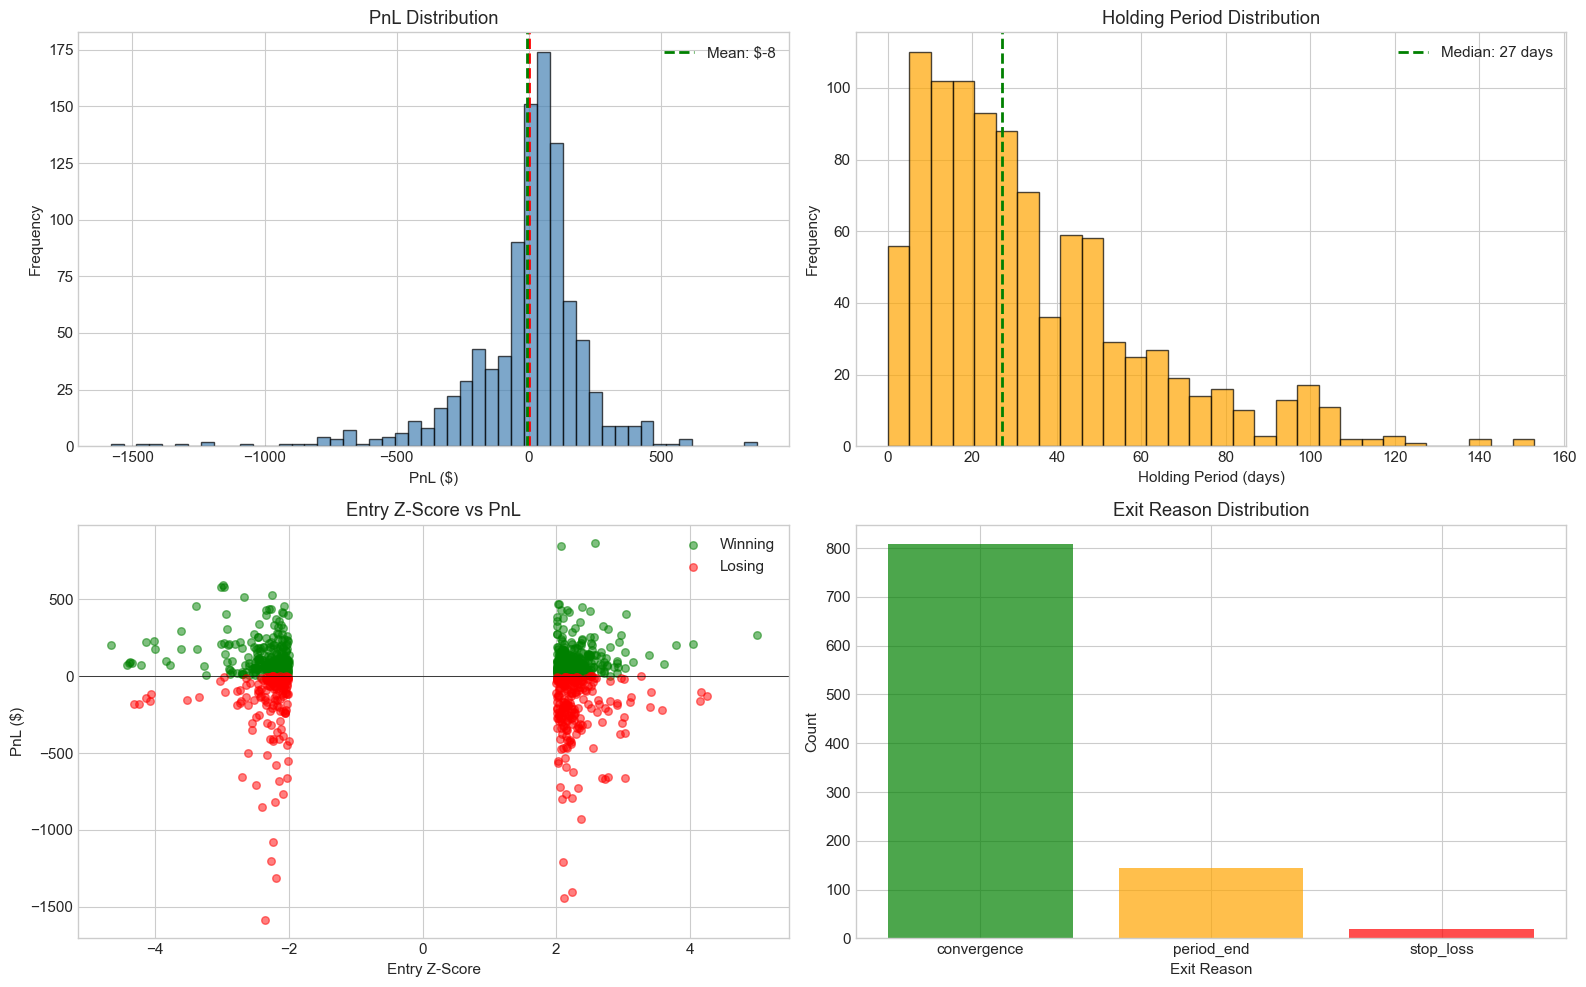

In [8]:
# PnL distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# PnL histogram
trades_df['pnl'].hist(bins=50, ax=axes[0, 0], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=trades_df['pnl'].mean(), color='green', linestyle='--', linewidth=2, 
                   label=f"Mean: ${trades_df['pnl'].mean():.0f}")
axes[0, 0].set_xlabel('PnL ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('PnL Distribution')
axes[0, 0].legend()

# Holding days distribution
trades_df['holding_days'].hist(bins=30, ax=axes[0, 1], color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=trades_df['holding_days'].median(), color='green', linestyle='--', linewidth=2,
                   label=f"Median: {trades_df['holding_days'].median():.0f} days")
axes[0, 1].set_xlabel('Holding Period (days)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Holding Period Distribution')
axes[0, 1].legend()

# Entry Z-score vs PnL
winning = trades_df[trades_df['pnl'] > 0]
losing = trades_df[trades_df['pnl'] <= 0]
axes[1, 0].scatter(winning['entry_z'], winning['pnl'], alpha=0.5, color='green', label='Winning', s=30)
axes[1, 0].scatter(losing['entry_z'], losing['pnl'], alpha=0.5, color='red', label='Losing', s=30)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Entry Z-Score')
axes[1, 0].set_ylabel('PnL ($)')
axes[1, 0].set_title('Entry Z-Score vs PnL')
axes[1, 0].legend()

# Exit reason breakdown
exit_counts = trades_df['exit_reason'].value_counts()
colors_exit = {'convergence': 'green', 'stop_loss': 'red', 'period_end': 'orange'}
axes[1, 1].bar(exit_counts.index, exit_counts.values, 
               color=[colors_exit.get(x, 'gray') for x in exit_counts.index], alpha=0.7)
axes[1, 1].set_xlabel('Exit Reason')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Exit Reason Distribution')

plt.tight_layout()
plt.savefig('I:/Winter-Break-Research/results/figures/trade_analysis.png', dpi=150)
plt.show()

In [9]:
# Exit reason analysis
exit_analysis = trades_df.groupby('exit_reason').agg({
    'pnl': ['count', 'sum', 'mean', 'std'],
    'holding_days': 'mean'
}).round(2)
exit_analysis.columns = ['Count', 'Total PnL', 'Avg PnL', 'Std PnL', 'Avg Holding Days']
exit_analysis['Win Rate %'] = trades_df.groupby('exit_reason').apply(
    lambda x: (x['pnl'] > 0).sum() / len(x) * 100
).round(1)

print("EXIT REASON ANALYSIS:")
print(exit_analysis.to_string())

print("\n" + "="*60)
print("KEY INSIGHT: Stop-loss trades are destroying profits!")
stop_loss = trades_df[trades_df['exit_reason'] == 'stop_loss']
convergence = trades_df[trades_df['exit_reason'] == 'convergence']
print(f"Stop-loss: {len(stop_loss)} trades, Total PnL: ${stop_loss['pnl'].sum():,.0f}")
print(f"Convergence: {len(convergence)} trades, Total PnL: ${convergence['pnl'].sum():,.0f}")

EXIT REASON ANALYSIS:
             Count  Total PnL  Avg PnL  Std PnL  Avg Holding Days  Win Rate %
exit_reason                                                                  
convergence    808   29967.73    37.09   181.71             33.27        68.2
period_end     144  -31730.12  -220.35   322.85             40.78        22.2
stop_loss       19   -5747.46  -302.50   199.90              9.26         0.0

KEY INSIGHT: Stop-loss trades are destroying profits!
Stop-loss: 19 trades, Total PnL: $-5,747
Convergence: 808 trades, Total PnL: $29,968


## 4. Phân Tích Theo Pair

In [10]:
# Pair-level analysis
pair_stats = trades_df.groupby('pair_str').agg({
    'pnl': ['count', 'sum', 'mean'],
    'holding_days': 'mean',
    'trading_year': lambda x: x.nunique()
}).round(2)
pair_stats.columns = ['Trade Count', 'Total PnL', 'Avg PnL', 'Avg Holding Days', 'Years Active']
pair_stats['Win Rate %'] = trades_df.groupby('pair_str').apply(
    lambda x: (x['pnl'] > 0).sum() / len(x) * 100
).round(1)

# Sort by total PnL
pair_stats = pair_stats.sort_values('Total PnL', ascending=False)

print("TOP 10 BEST PAIRS:")
print(pair_stats.head(10).to_string())

print("\nTOP 10 WORST PAIRS:")
print(pair_stats.tail(10).to_string())

TOP 10 BEST PAIRS:
          Trade Count  Total PnL  Avg PnL  Avg Holding Days  Years Active  Win Rate %
pair_str                                                                             
EWU-COPX            5    1571.61   314.32             22.80             1        80.0
VB-COPX             2    1193.62   596.81             28.00             1       100.0
VB-XME              5    1065.87   213.17             37.60             2       100.0
XLI-XRT             4     969.04   242.26             20.25             1       100.0
VB-IYW              4     954.34   238.58             17.50             1       100.0
EWC-ILF             2     905.12   452.56             15.00             1       100.0
VGT-IYT             4     892.52   223.13             15.50             1       100.0
XLV-DXJ             5     887.25   177.45             13.00             1       100.0
OIH-EWJ             3     856.32   285.44             14.67             1       100.0
VGT-EWC             4     802.56   

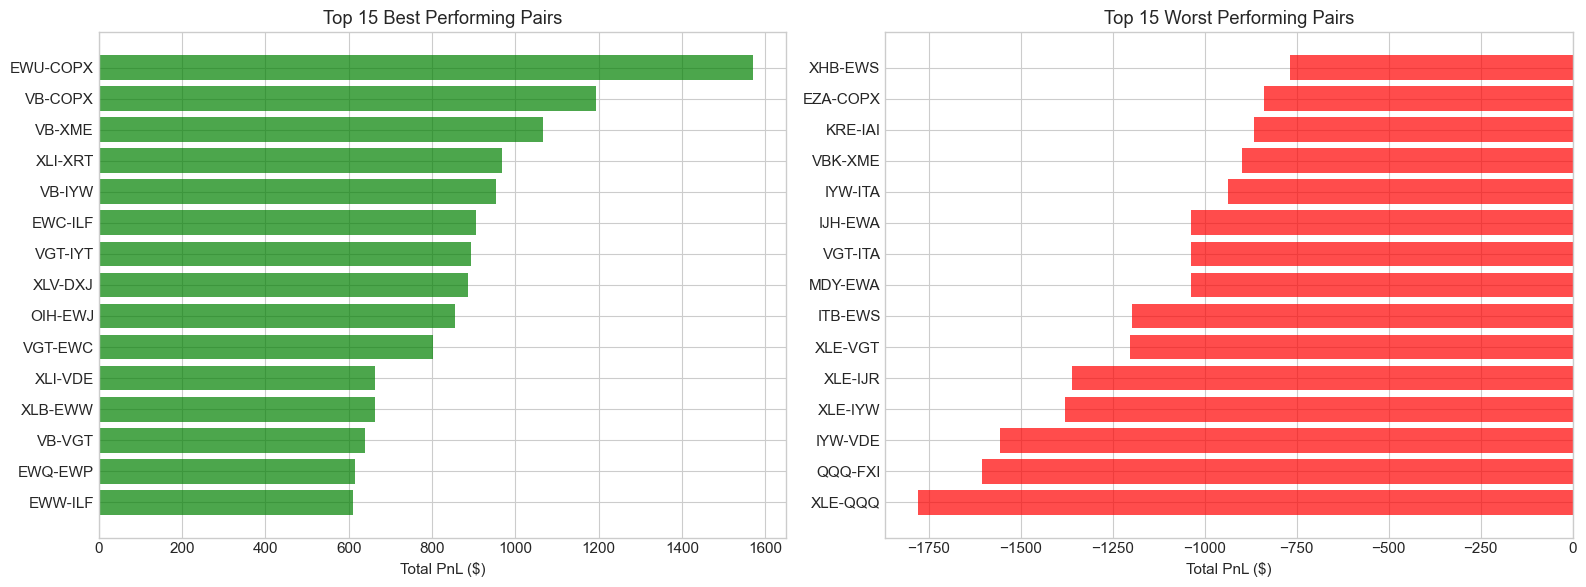

In [11]:
# Best vs worst pairs visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 pairs
top_pairs = pair_stats.head(15)
axes[0].barh(top_pairs.index, top_pairs['Total PnL'], color='green', alpha=0.7)
axes[0].set_xlabel('Total PnL ($)')
axes[0].set_title('Top 15 Best Performing Pairs')
axes[0].invert_yaxis()

# Bottom 15 pairs
bottom_pairs = pair_stats.tail(15)
axes[1].barh(bottom_pairs.index, bottom_pairs['Total PnL'], color='red', alpha=0.7)
axes[1].set_xlabel('Total PnL ($)')
axes[1].set_title('Top 15 Worst Performing Pairs')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('I:/Winter-Break-Research/results/figures/pair_analysis.png', dpi=150)
plt.show()

## 5. Phân Tích Sâu: Tại Sao Chiến Lược Thất Bại?

In [12]:
# Analysis 1: Long vs Short performance
direction_stats = trades_df.groupby('direction').agg({
    'pnl': ['count', 'sum', 'mean'],
}).round(2)
direction_stats.columns = ['Count', 'Total PnL', 'Avg PnL']
direction_stats['Win Rate %'] = trades_df.groupby('direction').apply(
    lambda x: (x['pnl'] > 0).sum() / len(x) * 100
).round(1)

print("LONG vs SHORT SPREAD ANALYSIS:")
print(direction_stats.to_string())

LONG vs SHORT SPREAD ANALYSIS:
           Count  Total PnL  Avg PnL  Win Rate %
direction                                       
LONG         443    6772.75    15.29        65.7
SHORT        528  -14282.60   -27.05        55.3


In [13]:
# Analysis 2: Entry Z-score buckets
trades_df['entry_z_bucket'] = pd.cut(trades_df['entry_z'].abs(), 
                                     bins=[0, 2.5, 3.0, 3.5, 4.0, np.inf],
                                     labels=['2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '>4.0'])

z_bucket_stats = trades_df.groupby('entry_z_bucket', observed=True).agg({
    'pnl': ['count', 'sum', 'mean'],
}).round(2)
z_bucket_stats.columns = ['Count', 'Total PnL', 'Avg PnL']
z_bucket_stats['Win Rate %'] = trades_df.groupby('entry_z_bucket', observed=True).apply(
    lambda x: (x['pnl'] > 0).sum() / len(x) * 100
).round(1)

print("ENTRY Z-SCORE BUCKET ANALYSIS:")
print(z_bucket_stats.to_string())
print("\n--> Extreme entries (|z| > 3) may indicate regime breaks, not mean reversion")

ENTRY Z-SCORE BUCKET ANALYSIS:
                Count  Total PnL  Avg PnL  Win Rate %
entry_z_bucket                                       
2.0-2.5           798  -11646.35   -14.59        59.3
2.5-3.0           124    2785.10    22.46        66.1
3.0-3.5            22     260.71    11.85        50.0
3.5-4.0             8     538.64    67.33        75.0
>4.0               19     552.05    29.06        57.9

--> Extreme entries (|z| > 3) may indicate regime breaks, not mean reversion


In [14]:
# Analysis 3: Holding period vs outcome
trades_df['holding_bucket'] = pd.cut(trades_df['holding_days'], 
                                     bins=[0, 5, 15, 30, 60, 120, np.inf],
                                     labels=['0-5d', '5-15d', '15-30d', '30-60d', '60-120d', '>120d'])

holding_stats = trades_df.groupby('holding_bucket', observed=True).agg({
    'pnl': ['count', 'sum', 'mean'],
}).round(2)
holding_stats.columns = ['Count', 'Total PnL', 'Avg PnL']
holding_stats['Win Rate %'] = trades_df.groupby('holding_bucket', observed=True).apply(
    lambda x: (x['pnl'] > 0).sum() / len(x) * 100
).round(1)

print("HOLDING PERIOD ANALYSIS:")
print(holding_stats.to_string())
print("\n--> Trades held too long (>60d) indicate cointegration breakdown")

HOLDING PERIOD ANALYSIS:
                Count  Total PnL  Avg PnL  Win Rate %
holding_bucket                                       
0-5d               54    4994.61    92.49        81.5
5-15d             212   20932.68    98.74        92.0
15-30d            283   24802.07    87.64        83.7
30-60d            272  -11875.34   -43.66        39.0
60-120d           140  -39047.92  -278.91         0.7
>120d               8   -7275.95  -909.49         0.0

--> Trades held too long (>60d) indicate cointegration breakdown


In [15]:
# Analysis 4: Stop-loss analysis - what went wrong?
stop_loss_trades = trades_df[trades_df['exit_reason'] == 'stop_loss'].copy()

print("STOP-LOSS DEEP DIVE:")
print(f"Total stop-loss trades: {len(stop_loss_trades)}")
print(f"Total loss from stop-loss: ${stop_loss_trades['pnl'].sum():,.0f}")
print(f"Average loss per stop-loss: ${stop_loss_trades['pnl'].mean():.0f}")
print(f"Average holding days before stop: {stop_loss_trades['holding_days'].mean():.1f}")

# Most common pairs hitting stop-loss
print("\nMost Common Pairs Hitting Stop-Loss:")
stop_loss_pairs = stop_loss_trades['pair_str'].value_counts().head(10)
print(stop_loss_pairs.to_string())

STOP-LOSS DEEP DIVE:
Total stop-loss trades: 19
Total loss from stop-loss: $-5,747
Average loss per stop-loss: $-302
Average holding days before stop: 9.3

Most Common Pairs Hitting Stop-Loss:
pair_str
EFA-EWP     2
SCHG-VFH    2
IWF-VFH     2
VGK-EWS     1
VB-XRT      1
IYW-IYT     1
QQQ-VTI     1
DVY-XRT     1
VYM-IYT     1
DIA-IYT     1


In [16]:
# Analysis 5: Market regime analysis
# Calculate S&P 500 (SPY) annual returns as market regime proxy
if 'SPY' in prices.columns:
    spy = prices['SPY'].dropna()
    spy_annual = spy.resample('Y').last().pct_change() * 100
    spy_annual.index = spy_annual.index.year
    spy_annual = spy_annual.rename('SPY_Return')
    
    # Merge with strategy returns
    regime_df = summary_df[['trading_year', 'return_pct']].copy()
    regime_df = regime_df.set_index('trading_year')
    regime_df = regime_df.join(spy_annual)
    
    print("MARKET REGIME ANALYSIS:")
    print(regime_df.to_string())
    
    # Correlation
    corr = regime_df['return_pct'].corr(regime_df['SPY_Return'])
    print(f"\nCorrelation between strategy and SPY returns: {corr:.2f}")
    print("(Low correlation = market neutral, High correlation = directional exposure)")
else:
    print("SPY not in price data - skipping market regime analysis")

MARKET REGIME ANALYSIS:
              return_pct  SPY_Return
trading_year                        
2008            0.007947  -36.794976
2009            3.687715   26.351662
2010           -1.329157   15.056169
2011           -2.257411    1.895008
2012            1.502428   15.990317
2013           -4.500656   32.307809
2014           -9.053872   13.463775
2015            0.642355    1.234294
2016            1.019738   11.997889
2017           -0.580180   21.705404
2018           -3.474842   -4.568998
2019           -0.376520   31.223871
2020            4.985851   18.331618
2021            1.706126   28.728750
2022            4.373395  -18.175363
2023           -3.438424   26.175803
2024           -0.424341   27.965330

Correlation between strategy and SPY returns: -0.11
(Low correlation = market neutral, High correlation = directional exposure)


## 6. Kết Luận và Đề Xuất Cải Thiện

In [17]:
# Summary of issues
print("="*70)
print("TỔNG KẾT VẤN ĐỀ VÀ ĐỀ XUẤT CẢI THIỆN")
print("="*70)

# Calculate key metrics
total_pnl = summary_df['total_pnl'].sum()
convergence_pnl = trades_df[trades_df['exit_reason'] == 'convergence']['pnl'].sum()
stop_loss_pnl = trades_df[trades_df['exit_reason'] == 'stop_loss']['pnl'].sum()
period_end_pnl = trades_df[trades_df['exit_reason'] == 'period_end']['pnl'].sum()

print(f"\n1. PnL BREAKDOWN:")
print(f"   Convergence trades: ${convergence_pnl:,.0f}")
print(f"   Stop-loss trades: ${stop_loss_pnl:,.0f}")
print(f"   Period-end trades: ${period_end_pnl:,.0f}")
print(f"   NET TOTAL: ${total_pnl:,.0f}")

print(f"\n2. VẤN ĐỀ CHÍNH:")
if stop_loss_pnl < 0 and abs(stop_loss_pnl) > convergence_pnl:
    print("   ❌ Stop-loss đang ăn hết lợi nhuận từ convergence trades")
    print("   --> Cân nhắc: Nới rộng stop-loss hoặc cải thiện pair selection")

avg_holding = trades_df['holding_days'].mean()
if avg_holding > 30:
    print(f"   ❌ Avg holding period quá dài ({avg_holding:.0f} days)")
    print("   --> Cân nhắc: Giảm max_half_life hoặc thắt chặt exit criteria")

losing_years = len(summary_df[summary_df['return_pct'] <= 0])
total_years = len(summary_df)
if losing_years > total_years / 2:
    print(f"   ❌ Thua lỗ {losing_years}/{total_years} năm")
    print("   --> Chiến lược không ổn định qua các năm")

print(f"\n3. ĐỀ XUẤT CẢI THIỆN:")
print("   A) PAIR SELECTION:")
print("      - Thêm rolling consistency check (pair phải stable qua nhiều window)")
print("      - Loại bỏ pairs có high stop-loss rate trong quá khứ")
print("   B) ENTRY CRITERIA:")
print("      - Tăng entry_z từ 2.0 lên 2.5 để có buffer lớn hơn")
print("      - Thêm momentum filter (không enter nếu trend mạnh)")
print("   C) EXIT CRITERIA:")
print("      - Dynamic stop-loss dựa trên half-life")
print("      - Time-based exit (force close sau X days)")
print("   D) POSITION SIZING:")
print("      - Giảm size cho pairs có volatility cao")
print("      - Scale out khi z-score giảm")

TỔNG KẾT VẤN ĐỀ VÀ ĐỀ XUẤT CẢI THIỆN

1. PnL BREAKDOWN:
   Convergence trades: $29,968
   Stop-loss trades: $-5,747
   Period-end trades: $-31,730
   NET TOTAL: $-7,510

2. VẤN ĐỀ CHÍNH:
   ❌ Avg holding period quá dài (34 days)
   --> Cân nhắc: Giảm max_half_life hoặc thắt chặt exit criteria
   ❌ Thua lỗ 9/17 năm
   --> Chiến lược không ổn định qua các năm

3. ĐỀ XUẤT CẢI THIỆN:
   A) PAIR SELECTION:
      - Thêm rolling consistency check (pair phải stable qua nhiều window)
      - Loại bỏ pairs có high stop-loss rate trong quá khứ
   B) ENTRY CRITERIA:
      - Tăng entry_z từ 2.0 lên 2.5 để có buffer lớn hơn
      - Thêm momentum filter (không enter nếu trend mạnh)
   C) EXIT CRITERIA:
      - Dynamic stop-loss dựa trên half-life
      - Time-based exit (force close sau X days)
   D) POSITION SIZING:
      - Giảm size cho pairs có volatility cao
      - Scale out khi z-score giảm


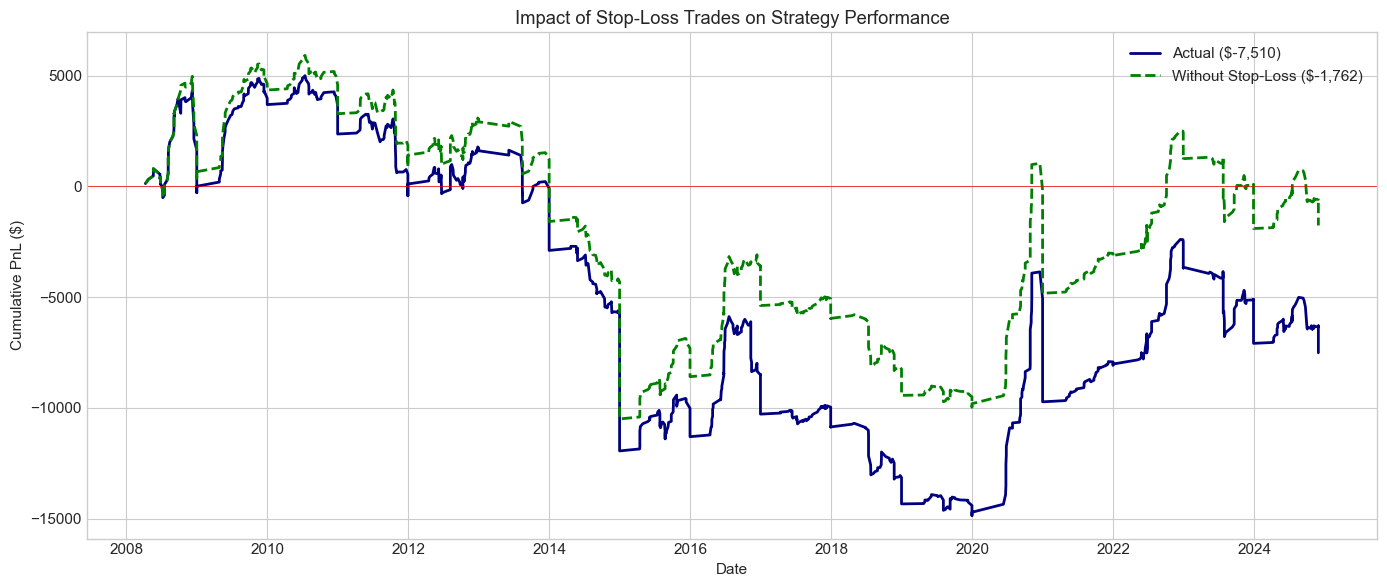


*** INSIGHT: Loại bỏ stop-loss trades sẽ tăng PnL từ $-7,510 lên $-1,762 ***
Điều này cho thấy cần cải thiện pair selection để tránh những pairs hay hit stop-loss


In [18]:
# Final visualization - what would happen if we eliminated stop-loss trades?
fig, ax = plt.subplots(figsize=(14, 6))

# Actual cumulative PnL
trades_df_sorted = trades_df.sort_values('exit_date')
trades_df_sorted['cumulative_pnl'] = trades_df_sorted['pnl'].cumsum()

# Hypothetical: without stop-loss trades
no_stop_loss = trades_df_sorted[trades_df_sorted['exit_reason'] != 'stop_loss'].copy()
no_stop_loss['cumulative_pnl'] = no_stop_loss['pnl'].cumsum()

ax.plot(trades_df_sorted['exit_date'], trades_df_sorted['cumulative_pnl'], 
        label=f'Actual (${total_pnl:,.0f})', linewidth=2, color='navy')
ax.plot(no_stop_loss['exit_date'], no_stop_loss['cumulative_pnl'], 
        label=f'Without Stop-Loss (${convergence_pnl + period_end_pnl:,.0f})', 
        linewidth=2, color='green', linestyle='--')

ax.axhline(y=0, color='red', linestyle='-', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL ($)')
ax.set_title('Impact of Stop-Loss Trades on Strategy Performance')
ax.legend()

plt.tight_layout()
plt.savefig('I:/Winter-Break-Research/results/figures/stop_loss_impact.png', dpi=150)
plt.show()

print(f"\n*** INSIGHT: Loại bỏ stop-loss trades sẽ tăng PnL từ ${total_pnl:,.0f} lên ${convergence_pnl + period_end_pnl:,.0f} ***")
print("Điều này cho thấy cần cải thiện pair selection để tránh những pairs hay hit stop-loss")